In [ ]:
# import modules
import numpy as np
import tensorflow as tf
import pickle
import gzip
import random
import time
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from IPython.display import Image, display
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu  # nltk == 3.4.5
from tqdm import tqdm_notebook as tqdm

In [ ]:
# return image feature dict, caption dict
def load_data(dtype):        
    image_ids = []
    features = dict()
    captions = dict()

    
    # get image ids
    image_ids = os.listdir('./data/{}_images'.format(dtype))
    image_ids = [x[:-4] for x in image_ids] # remove '.jpg'

    
    # get image captions
    with open('./data/{}_captions.txt'.format(dtype), 'r') as f:
        lines = f.read().split('\n')
        
        for l in lines:
            tokens = l.split(' ')
            image_id = tokens[0]
            caption = ' '.join(tokens[1:])

            if image_id in captions:
                captions[image_id].append(caption)
            else:
                captions[image_id] = [caption]

                
    # get image feature vector
    # you will make feature vector at first via pre-trained VGG16
    # then save it as file and reuse it
    # becuase extracting feature takes a lot of time
    

    # check if pickled feature file exists
    if os.path.isfile('./data/{}_features.pickle.zip'.format(dtype)):
        with gzip.open('./data/{}_features.pickle.zip'.format(dtype), 'rb') as f:
            features = pickle.load(f)
            
    else:
        # load VGG16
        start_time = time.time()
        model = VGG16()
        model = Model(inputs=model.inputs, outputs=model.layers[-2].output) # drop last prediction layer
        end_time = time.time()
        print('Elapsed for loading VGG16:', end_time-start_time, 'sec')
        
        
        # extracting feature using VGG16
        start_time = time.time()
        image_dir = './data/{}_images'.format(dtype)
        for i, filename in enumerate(os.listdir(image_dir)):
            image_path = './data/{}_images/{}'.format(dtype, filename)
            image = load_img(image_path, target_size=(224, 224, 3)) # VGG16 input size 
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0) # according to keras document
            image = preprocess_input(image) # according to keras document
            feature = model.predict(image)
            feature = np.squeeze(feature) # (1, 4096) -> (4096)
            image_id = filename.split('.')[0]
            features[image_id] = feature
            print('{0:>4}/{1:<4}-->{2}'.format(i+1, len(os.listdir(image_dir)), image_id), end='\r')
        
        end_time = time.time()
        print('Elapsed for extracting feature:', end_time-start_time, 'sec')
        
        
        # saving feature as file
        start_time = time.time() 
        with gzip.open('./data/{}_features.pickle.zip'.format(dtype), 'wb') as f:
            pickle.dump(features, f)
            
        end_time = time.time()
        print('Elapsed for saving feature:', end_time-start_time, 'sec')
        
    print('End loading {} data'.format(dtype))
    return features, captions

In [ ]:
train_features, train_captions = load_data('train')
test_features, test_captions = load_data('test')

End loading train data
End loading test data


In [ ]:
print('# of images in train:', len(train_features), len(train_captions))
print('# of images in test:', len(test_features), len(test_captions))

image_id = list(train_features.keys())[0]
print('feature example')
print(train_features[image_id])
print('shape:', train_features[image_id].shape)
print('caption example')
print(train_captions[image_id])

# of images in train: 6000 6000
# of images in test: 1000 1000
feature example
[0. 0. 0. ... 0. 0. 0.]
shape: (4096,)
caption example
['group of asian children are part of an audience sitting on blue benches', 'four kids turn around to be photographed', 'little girls ignoring the current adult procession going on', 'some children turned backwards while in the audience', 'three young girls posing for picture in an outdoor amphitheater surrounded by adults watching conference']


In [ ]:
# check if wrong key(image_id) in feature dict and caption dict
key_tr_feat = set([x for x in train_features])
key_tr_capt = set([x for x in train_captions])
print(key_tr_capt - key_tr_feat)
print(key_tr_feat - key_tr_capt)

set()
set()


In [ ]:
# return word_to_idx, idx_to_word, vocab_size
def preprocess_vocab(captions):
    threshold = 20 # threshold of occurence
    count = dict()
    word_to_idx, idx_to_word = dict(), list()

    for caption_list in captions.values():
        for c in caption_list:
            tokens = c.split(' ')
            for t in tokens:
                if t in count:
                    count[t] += 1
                else:
                    count[t] = 1
            
    print('# total of words:', len(count))
    print('# of words that appears >= {}:'.format(threshold), len([w for w in count if count[w] >= threshold]))

    idx_to_word = [w for w in count if count[w] >= threshold]
    idx_to_word.append('<START>')
    idx_to_word.append('<END>')
    for i, w in enumerate(idx_to_word):
        word_to_idx[w] = i
        
    return word_to_idx, idx_to_word, len(idx_to_word)
    
    

In [ ]:
# vocab_size: 우리가 사용할 총 단어의 수
# 각 caption을 index vector로 encoding할 수 있음
word_to_idx, idx_to_word, vocab_size = preprocess_vocab(train_captions)
print('vocab_size:', vocab_size)

# total of words: 7576
# of words that appears >= 20: 1065
vocab_size: 1067


In [ ]:
# train set을 만듬
# ex) feature: cap1, cap2, cap3, cap4, cap5
# -> [feature, ... feature], [cap1, ... cap5]
def dict_to_list(features, captions):
    image_ids, feat, capt = [], [], []
    for image_id in features:
        _feat = features[image_id]
        _capt = captions[image_id]
        for c in _capt:
            image_ids.append(image_id)
            feat.append(_feat)
            c = '<START> ' + c + ' <END>'
            capt.append(c)
            
    return image_ids, np.array(feat), np.array(capt)

In [ ]:
def display_image(image_id):
    if os.path.isfile('./data/train_images/{}.jpg'.format(image_id)):
        image_filename = './data/train_images/' + image_id + '.jpg'
    elif os.path.isfile('./data/test_images/{}.jpg'.format(image_id)):
        image_filename = './data/test_images/' + image_id + '.jpg'        
        
    else:
        assert os.path.isfile(image_id), 'specify image path'

    display(Image(filename=image_filename))

len(image_ids): 30000
len(feat): 30000
len(capt): 30000


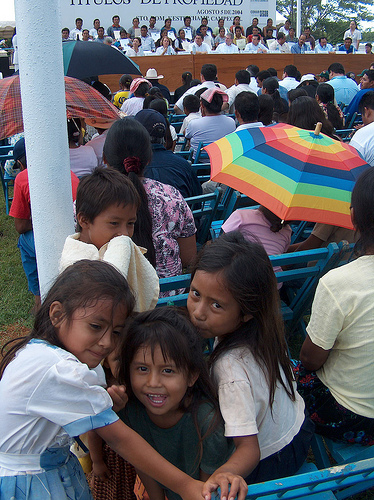

3217056901_fe2c70377d [0. 0. 0. ... 0. 0. 0.] <START> group of asian children are part of an audience sitting on blue benches <END>


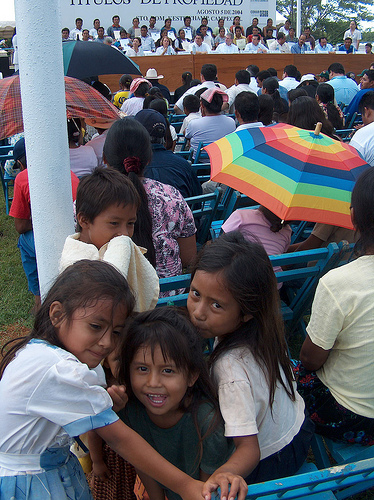

3217056901_fe2c70377d [0. 0. 0. ... 0. 0. 0.] <START> four kids turn around to be photographed <END>


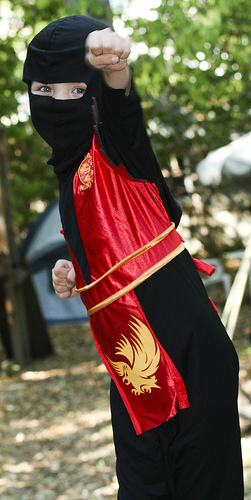

1420060020_7a6984e2ea [0.01913381 0.         0.         ... 0.         0.         1.8505907 ] <START> child in black overall karate costume with red front and yellow bird on it attacking <END>


In [ ]:
image_ids, feats, capts = dict_to_list(train_features, train_captions)
print('len(image_ids):', len(image_ids))
print('len(feat):', len(feats))
print('len(capt):', len(capts))
display_image(image_ids[0])
print(image_ids[0], feats[0], capts[0])
display_image(image_ids[1])
print(image_ids[1], feats[1], capts[1])
display_image(image_ids[6])
print(image_ids[6], feats[6], capts[6])